In [1]:
import numpy as np
import pandas as pd
import time

# matplotlib and seaborn for visualizing the data

import matplotlib.pyplot as plt
import seaborn as sns

# Counter for counting the number of data points in each clusters

from collections import Counter

# Necessary modules for Standardising the data and using ML algorithms
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler,normalize
from sklearn.neighbors import NearestNeighbors


# silhouette_score for evaluating the clusters, ranges from -1 to +1, desirable score is close to 1

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import euclidean_distances
import plotly.express as px


In [16]:
df = pd.read_csv("Basket_dataset.csv")
df.head()

,Member_number,Date,itemDescription
0,1808,21/07/2015,tropical fruit
1,2552,05/01/2015,whole milk
2,2300,19/09/2015,pip fruit
3,1187,12/12/2015,other vegetables
4,3037,01/02/2015,whole milk


In [17]:
#creating database
import sqlite3
conn= sqlite3.connect("Groceries")
cur= conn.cursor()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [20]:
df['Date'] = pd.to_datetime(df['Date'] )
df['Date'].head()

0   2015-07-21
1   2015-01-05
2   2015-09-19
3   2015-12-12
4   2015-02-01
Name: Date, dtype: datetime64[ns]

In [21]:
#load CRM data into the RFMdb database
#df.to_sql("Groceries_dataset", conn)

In [22]:
Sales_weekly = df.resample('w', on='Date').size()
fig = px.line(Sales_weekly, x=Sales_weekly.index, y=Sales_weekly,
              labels={'y': 'Member_number',
                     'x': 'Date'})
fig.update_layout(title_text='Number of Member_number Weekly',
                  title_x=0.5, title_font=dict(size=18)) 
fig.show()

In [8]:
Sales_Monthly = df.resample('M', on='Date').size()
fig = px.line(Sales_Monthly, x=Sales_Monthly.index, y=Sales_Monthly,
              labels={'y': 'Member_number',
                     'x': 'Date'})
fig.update_layout(title_text='Number of Member_number Monthly',
                  title_x=0.5, title_font=dict(size=18)) 
fig.show()

In [9]:
user_item = df.groupby(pd.Grouper(key='Member_number')).size().reset_index(name='count') \
    .sort_values(by='count', ascending=False)
fig = px.bar(user_item.head(10), x='Member_number', y='count',
             labels={'y': 'Number of Member_number',
                     'count': 'Number of Items Bought'},
             color='count')
fig.update_layout(title_text='Top 20 Members regarding Number of Items Bought',
                  title_x=0.5, title_font=dict(size=18))
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.show()

In [10]:
baskets = df.groupby(['Member_number'])['itemDescription'].count()
baskets.reset_index()
baskets.head()

Member_number
1000    13
1001    12
1002     8
1003     8
1004    21
Name: itemDescription, dtype: int64

In [23]:

result_df = df.groupby('Member_number').agg(
    last_order_date=('Date', 'max'),
    transaction_number=('Date', 'count'),
    count_order_sum=('itemDescription', 'count')
).reset_index()

# Filtering out rows with NULL Member_number or Date
result_df = result_df.dropna(subset=['Member_number', 'last_order_date'])

result_df.head()

,Member_number,last_order_date,transaction_number,count_order_sum
0,1000,2015-11-25,13,13
1,1001,2015-05-02,12,12
2,1002,2015-08-30,8,8
3,1003,2015-02-10,8,8
4,1004,2015-12-02,21,21


In [12]:
import plotly.express as px

Frequency_of_items = df.groupby(pd.Grouper(key='itemDescription')).size().reset_index(name='count')
fig = px.treemap(Frequency_of_items, path=['itemDescription'], values='count')
fig.update_layout(title_text='Frequency of the Items Sold',
                  title_x=0.5, title_font=dict(size=18)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [24]:
df['DayOfWeek'] = df['Date'].dt.day_of_week
df['Month'] = df['Date'].dt.month
df.head()

,Member_number,Date,itemDescription,DayOfWeek,Month
0,1808,2015-07-21,tropical fruit,1,7
1,2552,2015-01-05,whole milk,0,1
2,2300,2015-09-19,pip fruit,5,9
3,1187,2015-12-12,other vegetables,5,12
4,3037,2015-02-01,whole milk,6,2


In [25]:
conn.execute("DROP TABLE IF EXISTS cleandata")

# Grouping number of items (orders) for each member and each date.
cleandata1= pd.read_sql('''SELECT Member_number,
                    Date,
                    COUNT(*) AS Item_count
            FROM Groceries_dataset
            WHERE Member_number IS NOT NULL
            AND Date IS NOT NULL
            GROUP BY Member_number, Date''', conn)

cleandata1.to_sql("cleandata1", conn)
cleandata1

ValueError: Table 'cleandata1' already exists.

In [26]:
conn.execute("DROP TABLE IF EXISTS cleandata2")

# For RFM, fetching member's last purchase date, total number of times items are purchased, total items purchased
cleandata2= pd.read_sql('''SELECT Member_number,
                    MAX(Date) as Last_purchase_date,
                    Count(Date) as Total_transactions,
                    SUM(Item_count) as Total_items_purchased
            FROM cleandata1
            WHERE Member_number IS NOT NULL
            AND Date IS NOT NULL
            GROUP BY Member_number''', conn)

cleandata2.to_sql("cleandata2", conn)
cleandata2

,Member_number,Last_purchase_date,Total_transactions,Total_items_purchased
0,1000,2015-11-25 00:00:00,5,13
1,1001,2015-05-02 00:00:00,5,12
2,1002,2015-08-30 00:00:00,4,8
3,1003,2015-02-10 00:00:00,4,8
4,1004,2015-12-02 00:00:00,8,21
...,...,...,...,...
3893,4996,2015-11-24 00:00:00,3,10
3894,4997,2015-12-27 00:00:00,2,6
3895,4998,2015-10-14 00:00:00,1,2
3896,4999,2015-12-26 00:00:00,6,16


In [32]:
import datetime

In [34]:
cleandata2['Last_purchase_date'] = pd.to_datetime(cleandata2['Last_purchase_date'])

In [36]:
#Recency value
# Creating snapshot date to find the recency
snapshot_dt = cleandata2 ['Last_purchase_date'].max() + datetime.timedelta(days=1)
print(snapshot_dt)
cleandata1

# Aggregate data by each customer
members = cleandata2 .groupby(['Member_number']).agg({
   'Last_purchase_date': lambda x: (snapshot_dt - x.max()).days,
   'Total_items_purchased':'sum',
   'Total_transactions':'sum'
   })
members

members.rename(columns = {'Last_purchase_date': 'Recency','Total_transactions': 'Frequency',
                          'Total_items_purchased': 'MonetaryValue',}, inplace=True)
members

2015-12-31 00:00:00


,Recency,MonetaryValue,Frequency
Member_number,,,
1000,36,13,5
1001,243,12,5
1002,123,8,4
1003,324,8,4
1004,29,21,8
...,...,...,...
4996,37,10,3
4997,4,6,2
4998,78,2,1


<Figure size 1200x1000 with 0 Axes>

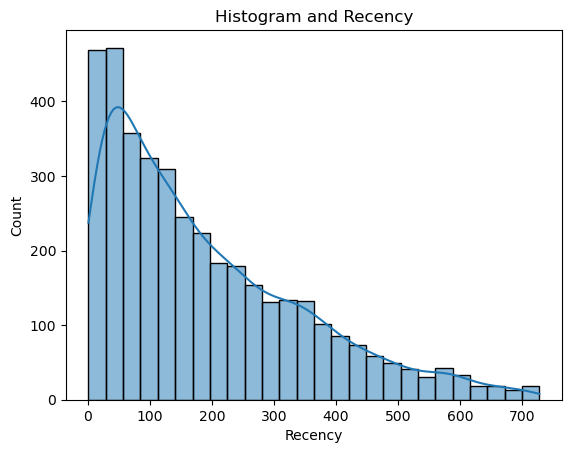

<Figure size 1200x1000 with 0 Axes>

In [37]:
#distrubution analysis for recency
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()
sns.histplot(data=members, x='Recency', kde=True)
ax.set_title('Histogram and Recency')

members_fix = pd.DataFrame()
members_fix["Recency"] = members['Recency']
plt.figure(figsize=(12,10))

Text(0.5, 1.0, 'Histogram and Frequency')

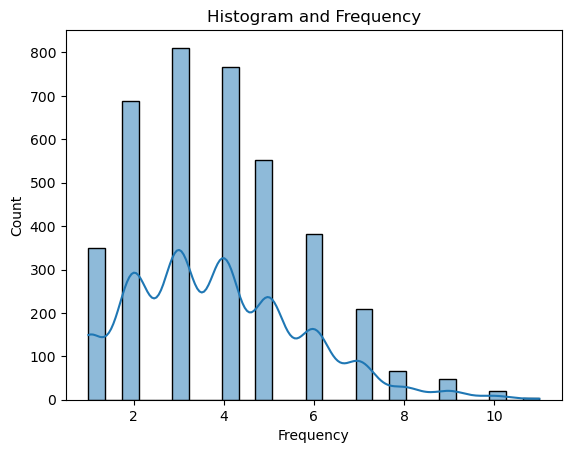

In [38]:
#distrubution analysis for frequency
fig, ax = plt.subplots()
sns.histplot(data=members, x='Frequency', kde=True)
ax.set_title('Histogram and Frequency')

Text(0.5, 1.0, 'Histogram and MonetaryValue')

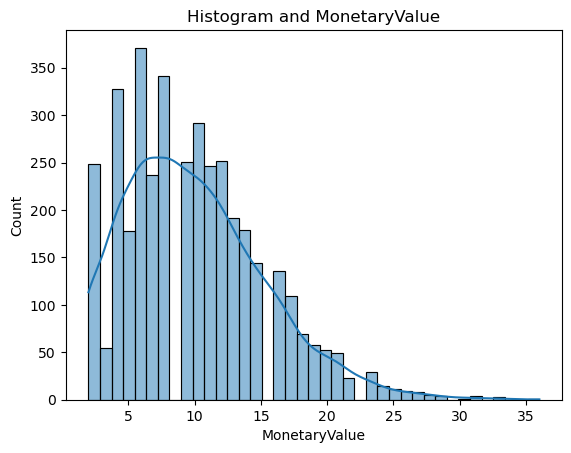

In [39]:
fig, ax = plt.subplots()
sns.histplot(data=members, x='MonetaryValue', kde=True)
ax.set_title('Histogram and MonetaryValue')

C:\Users\PRAGYA\AppData\Local\Temp\ipykernel_52144\2780309877.py:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\PRAGYA\AppData\Local\Temp\ipykernel_52144\2780309877.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\PRAGYA\AppData\Local\Temp\ipykernel_52144\2780309877.py:11: UserWarning:



`distplo

<Axes: xlabel='MonetaryValue', ylabel='Density'>

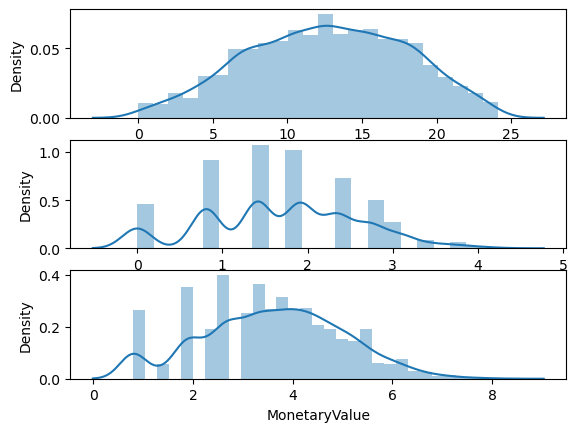

In [40]:
#Box-cox transformation
members_fix["Frequency"] = stats.boxcox(members['Frequency'])[0]
members_fix["MonetaryValue"] = stats.boxcox(members['MonetaryValue'])[0]
members_fix["Recency"] = stats.boxcox(members['Recency'])[0]



# Plot distributions after transformation
plt.subplot(3, 1, 1); sns.distplot(members_fix['Recency'])
plt.subplot(3, 1, 2); sns.distplot(members_fix['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(members_fix['MonetaryValue'])



In [ ]:
df

In [41]:
baskets = df.groupby(['Member_number', 'itemDescription'])['itemDescription'].count().unstack().fillna(0).reset_index()
baskets.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [47]:
len(baskets.columns)

168

In [42]:
#Before rfm analysis put everything into normalized, same mean variance 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(members_fix)
members_normalized = scaler.transform(members_fix)

# Assert that it has mean 0 and variance 1
print(members_normalized.mean(axis = 0).round(2)) # [0. -0. -0.]
print(members_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


In [43]:
members_fix

,Recency,Frequency,MonetaryValue
Member_number,,,
1000,6.924928,2.340087,4.565432
1001,15.792943,2.340087,4.338106
1002,11.966281,1.909001,3.295342
1003,17.690836,1.909001,3.295342
1004,6.232993,3.398871,6.096896
...,...,...,...
4996,7.016236,1.412097,3.847542
4997,1.763905,0.810273,2.654617
4998,9.852175,0.000000,0.802660


In [44]:
members_normalized

array([[-1.08371146,  0.70026717,  0.67975949],
       [ 0.58868218,  0.70026717,  0.51878012],
       [-0.13297708,  0.22464313, -0.21964795],
       ...,
       [-0.53167025, -1.881588  , -1.9848287 ],
       [-1.98753125,  1.12502636,  1.1230575 ],
       [ 0.94660026, -0.32359904, -0.43696874]])

In [45]:
#clean the data and calculate rfm values
df_Fact = pd.read_sql(''' SELECT Member_number, rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined
    FROM
     ( SELECT Member_number,
             NTILE(4) OVER (ORDER BY Last_purchase_date) AS rfm_recency,
             NTILE(4) OVER (ORDER BY Total_items_purchased) AS rfm_frequency,
             NTILE(4) OVER (ORDER BY Total_transactions) AS rfm_monetary
      FROM
            cleandata2
      Order By Member_number
            )
 ''', conn)
df_Fact

,Member_number,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,1000,4,3,3,433
1,1001,2,3,3,233
2,1002,3,2,2,322
3,1003,1,2,2,122
4,1004,4,4,4,444
...,...,...,...,...,...
3893,4996,4,3,2,432
3894,4997,4,1,2,412
3895,4998,3,1,1,311
3896,4999,4,4,4,444


In [46]:
def rfm_level(df_Fact):
    if ((df_Fact['rfm_recency'] >= 4) and (df_Fact['rfm_frequency'] >= 4)
        and (df_Fact['rfm_monetary'] >= 4)):
        return 'Best Customers'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 3)
          and (df_Fact['rfm_monetary'] >= 3)):
        return 'Loyal'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 1)):
        return 'Promising'
    elif ((df_Fact['rfm_recency'] >= 2) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'At Risk'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

#Create a new variable rfm_level
df_Fact['rfm_level'] = df_Fact.apply(rfm_level, axis=1)
df_Fact

,Member_number,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,1000,4,3,3,433,Loyal
1,1001,2,3,3,233,Customers Needing Attention
2,1002,3,2,2,322,Potential Loyalist
3,1003,1,2,2,122,At Risk
4,1004,4,4,4,444,Best Customers
...,...,...,...,...,...,...
3893,4996,4,3,2,432,Potential Loyalist
3894,4997,4,1,2,412,Potential Loyalist
3895,4998,3,1,1,311,Promising
3896,4999,4,4,4,444,Best Customers


In [ ]:
# Define a mapping dictionary for rfm_level categories
rfm_level_map = {
    'Best Customers': 7,
    'Loyal': 6,
    'Potential Loyalist': 5,
    'Promising': 4,
    'Customers Needing Attention': 3,
    'At Risk': 2,
    'Hibernating': 1,
    'Lost': 0
}

# Create a new column 'rfm_level_code' by mapping the 'rfm_level' column
df_Fact['rfm_level_code'] = df_Fact['rfm_level'].map(rfm_level_map)

# Display the DataFrame with the new column
print(df_Fact)

In [ ]:
!pip install squarify

In [ ]:
# Calculate total customers in each segment
rfm_agg = df_Fact.groupby('rfm_level').agg({'Member_number':'count'})
print(rfm_agg)

In [ ]:
#RFM visualization
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 3)
squarify.plot(sizes=rfm_agg['Member_number'],
              label=['At Risk',
                     'Best Customers',
                     'Customers Needing Attention',
                     'Hibernating',
                     'Lost',
                     'Loyal',
                     'Potential Loyalist',
                     'Promising'], alpha=0.8)
plt.title("RFM Segments",fontsize=15)
plt.axis('off')
plt.show()


In [ ]:
df_Fact

In [ ]:
df_Fact.columns

In [ ]:

plt.scatter(df_Fact.rfm_combined, df_Fact.rfm_level)
plt.show()

In [ ]:
# !pip install yellowbrick

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))
pyplot.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_Fact[['rfm_recency', 'rfm_frequency', 'rfm_monetary','rfm_combined']], method='ward'))

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))
pyplot.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_Fact[['rfm_recency', 'rfm_frequency', 'rfm_monetary','rfm_combined']], method='centroid'))

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))
pyplot.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_Fact[['rfm_recency', 'rfm_frequency', 'rfm_monetary','rfm_combined']], method='complete'))

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))
pyplot.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_Fact[['rfm_combined','rfm_level_code']], method='complete'))

In [ ]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True,n_init='auto')
visualizer.fit(members_normalized1)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [ ]:
# Elbow diagram to set K value, for the K-Means
from sklearn.cluster import KMeans
sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(members_normalized1)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroidplt.title('The Elbow Method')

plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
from kneed import KneeLocator
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()

    kneedle = KneeLocator(x = range(1, len(distances)+1), y = distances, S = 1.0,
                          curve = "concave", direction = "increasing", online=True)

    # get the estimate of knee point
    print(kneedle.knee_y)
    kneedle.plot_knee()
    plt.show()



k = 2 * members_normalized.shape[-1] - 1 # k=2*{dim(dataset)} - 1
print(k)
get_kdist_plot(X=members_normalized, k=k)

In [ ]:
# output = []
# eps_range = np.arange(0.1,0.68, 0.05) # returns array of ranging from 0.05 to 0.13 with step of 0.01
# # min_samples_range = range(4,8)
# for eps_val in eps_range:
#     model = cluster.DBSCAN(eps=eps_val,min_samples = 8)
#     model.fit(members_normalized)
#     try:
#         score = silhouette_score(members_normalized, model.labels_)
#         # print(score)
#         if (len(set(model.labels_)))<10 and (len(set(model.labels_)))>4:
#             if score > 0:
#                 print(score,eps_val,min_samples_val)
#             output.append((eps_val,min_samples_val,score))
# #             else:
# #                 print(len(set(model.labels_)))
#     except:
#         pass
# Epsilon_val,min_samples_val, score = sorted(output, key=lambda x:x[-1])[-1]
# print("-"*100)
# print(f"Best silhouette_score: {score}")
# print(f"Epsilon_val: {Epsilon_val}")
# print(f"min_samples_val: {min_samples_val}")

In [ ]:
output = []
eps_range = np.arange(0.1,0.68, 0.05) # returns array of ranging from 0.05 to 0.13 with step of 0.01
min_samples_range = range(2,16)
for eps_val in eps_range:
    for min_samples_val in min_samples_range:
        model = cluster.DBSCAN(eps=eps_val,min_samples = min_samples_val)
        model.fit(members_normalized)
        try:
            score = silhouette_score(members_normalized, model.labels_)
            # print(score)
            if (len(set(model.labels_)))<9 and (len(set(model.labels_)))>5:
                if score > 0:
                    print(score,eps_val,min_samples_val,len(set(model.labels_)))
                output.append((eps_val,min_samples_val,score))
#             else:
#                 print(len(set(model.labels_)))
        except:
            pass
Epsilon_val,min_samples_val, score = sorted(output, key=lambda x:x[-1])[-1]
print("-"*100)
print(f"Best silhouette_score: {score}")
print(f"Epsilon_val: {Epsilon_val}")
print(f"min_samples_val: {min_samples_val}")

In [ ]:
db = DBSCAN(eps=Epsilon_val, min_samples=min_samples_val).fit(members_normalized)

members_fix['Labels'] = db.labels_
members_fix

In [ ]:
plt.figure(figsize=(11, 6))
sns.scatterplot(x="Recency", y="Frequency", data = members_fix, hue=members_fix.Labels,
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
#plt.title('DBSCAN with epsilon 10.63, min samples 4')
plt.show()

In [ ]:
members_fix.groupby('Labels').agg({
   'Recency':'mean',
   'Frequency':'mean',
   'MonetaryValue':['mean', 'count']}).round(2)

In [ ]:
plt.figure(figsize=(11, 6))
sns.scatterplot(x="MonetaryValue", y="Labels", data = members_fix, hue=members_fix.Labels,
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
#plt.title('DBSCAN with epsilon 10.63, min samples 4')
plt.show()

In [ ]:
df_normalized = pd.DataFrame(members_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = members_fix.index
df_normalized['Cluster'] = db.labels_

# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

# Visualize it
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)

In [ ]:
model = KMeans(n_clusters=5, random_state=0) 

model.fit(members_normalized)
model.labels_.shape
members_fix["Cluster"] = model.labels_

members_fix.groupby('Cluster').agg({
   'Recency':'mean',
   'Frequency':'mean',
   'MonetaryValue':['mean', 'count']}).round(2)